In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
#Datos
cafe = pd.read_csv("ASASSN-VJ125312.38-675751.3.csv")
cafe = cafe.sort_values('hjd')

In [4]:
#Filtrar outliers
cafe = cafe[(cafe['mag'] >= 13.3) & (cafe['mag'] <= 15.6)]
print("Filas después de filtrar:", len(cafe))

Filas después de filtrar: 506


In [5]:
#Plegado de fase
period = 3.40136  # Período de la Cefeida (días)
cafe['phase'] = (cafe['hjd'] % period) / period  # Fase entre 0 y 1
cafe = cafe.sort_values('phase')  # Ordenar por fase

In [6]:
#Suavizado con promedio móvil
window_size = 5  # Ajusta según el nivel de ruido
cafe['mag_smooth'] = cafe['mag'].rolling(window=window_size, center=True).mean()
cafe = cafe.dropna()  # Eliminar filas con NaN después del suavizado
print("Filas después de suavizado:", len(cafe))

Filas después de suavizado: 502


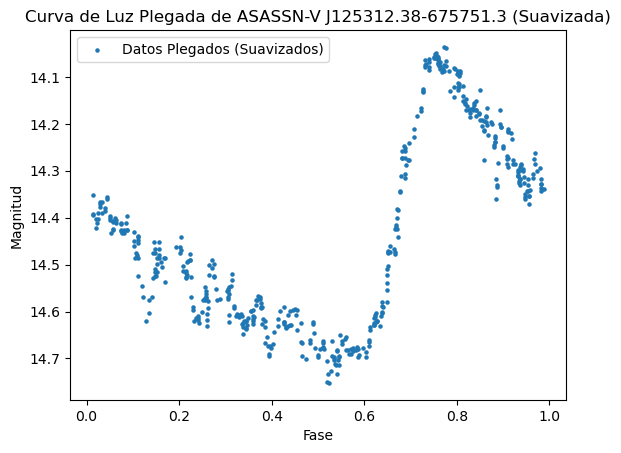

In [7]:
#Graficamos la curva de luz plegada
plt.scatter(cafe['phase'], cafe['mag_smooth'], s=5, label="Datos Plegados (Suavizados)")
plt.title("Curva de Luz Plegada de ASASSN-V J125312.38-675751.3 (Suavizada)")
plt.xlabel("Fase")
plt.ylabel("Magnitud")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [8]:
#magnitud suavizada
magnitude = cafe['mag_smooth'].values
cafe_values = magnitude.reshape(-1, 1)

In [9]:
# Normalizamos
scaler = MinMaxScaler()
cafe_normalized = scaler.fit_transform(cafe_values)

In [10]:
# Crear secuencias
def create_sequences(cafe, seq_length):
    X, y = [], []
    for i in range(len(cafe) - seq_length):
        X.append(cafe[i:i + seq_length])
        y.append(cafe[i + seq_length])
    X = np.array(X)
    y = np.array(y)
    print("Forma de X:", X.shape, "Forma de y:", y.shape)
    return X, y

seq_length = 20
X, y = create_sequences(cafe_normalized, seq_length)

Forma de X: (482, 20, 1) Forma de y: (482, 1)


In [12]:
#Dividimos en entrenamiento y prueba
train_size = int(0.8 * len(X))
print("Tamaño de entrenamiento:", train_size)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

Tamaño de entrenamiento: 385


In [ ]:
#Modelo
model = Sequential([
    LSTM(128, input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1)
])

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

In [15]:
#Entrenamiento
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2848 - val_loss: 0.0128
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0156 - val_loss: 0.0216
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0088 - val_loss: 0.0175
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0078 - val_loss: 0.0150
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0069 - val_loss: 0.0138
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0070 - val_loss: 0.0129
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0057 - val_loss: 0.0125
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0070 - val_loss: 0.0100
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

In [16]:
#Predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


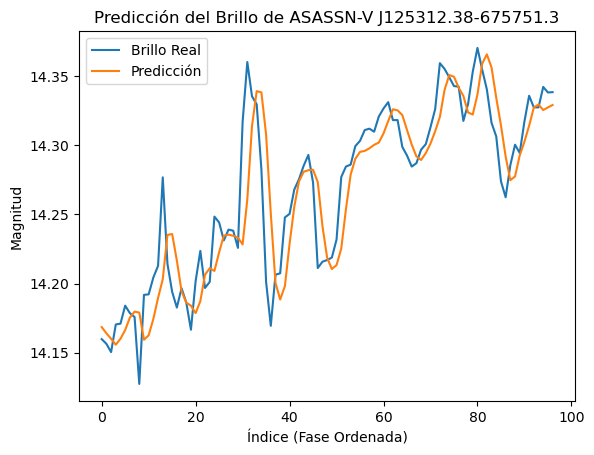

In [45]:
#Graficamos la predicción
plt.plot(y_test, label="Brillo Real")
plt.plot(predictions, label="Predicción")
plt.legend()
plt.title("Predicción del Brillo de ASASSN-V J125312.38-675751.3")
plt.xlabel("Índice (Fase Ordenada)")
plt.ylabel("Magnitud")
plt.show()

In [49]:
#Calculamos MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae:.4f}")

MAE: 0.0211


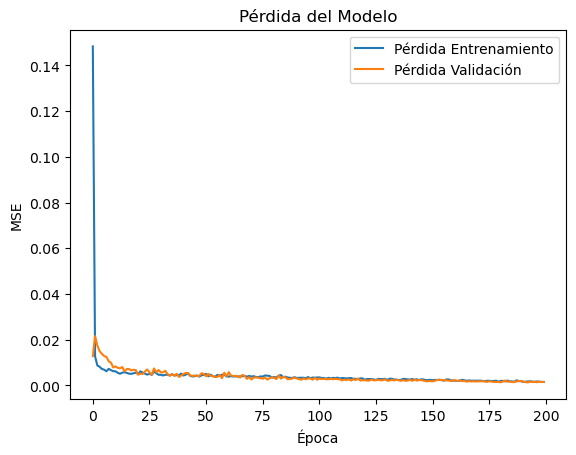

In [51]:
#Graficamos pérdida
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.title("Pérdida del Modelo")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.show()

## $\textcolor{purple}{\text{Conclusiones}}$

El modelo LSTM capturó las oscilaciones periódicas de $ASASSN-V J125312.38-675751.3$ tras aplicar suavizado y plegado de fase, logrando un $\text{MAE}$ de $0.0211$.

La gráfica $1$ muestra que las predicciones siguen de cerca las oscilaciones de $3.40136$ días de la Cefeida, logrando así el objetivo de predecir el patrón periódico del brillo. Así pues, en la gráfica $2$ podemos ver un aprendizaje estable con un $\text{MSE}$ final de $0.01$.